# Urban Sounds 8k Classification with Hugging Face Demo
> First tutorial using fastpages Jupyter notebook blog - Deploy a fast ai model to HuggingFaces

- toc: true 
- badges: true
- comments: true
- categories: [sound, hugging face, fastai]
- image: images/melspectrogram.png

## Hugging Face Demo

Here is a demo of what this model at Hugging Face : [Urban Sound 8K Classification](https://huggingface.co/spaces/gputrain/UrbanSounds8K)

## Background 

Urban Sounds is a dataset of 8732 labeled sounds of less than 4 seconds each from 10 classes. Dataset for [UrbanSounds8K](https://urbansounddataset.weebly.com/urbansound8k.html) contains these 10 classes:

1.  air_conditioner
2.  car_horn
3.  children_playing
4.  dog_bark
5.  drilling
6.  engine_idling
7.  gun_shot
8.  jackhammer
9.  siren
10. street_music


[Research with this dataset as of 2019](https://www.researchgate.net/publication/335862311_Evaluation_of_Classical_Machine_Learning_Techniques_towards_Urban_Sound_Recognition_on_Embedded_Systems) and optimized ML approaches as of late 2019 had classification accuracy at 74% with a k-nearest neighbours (KNN) algorithm. A deep learning neural network trained from scratch obtained accuracy at 76% accuracy.


![Accuracy metrics](https://www.researchgate.net/profile/Bruno-Silva-172/publication/335862311/figure/fig2/AS:804132151652353@1568731453277/Achieved-accuracy-of-the-classifiers-with-their-default-and-optimized-configuration.png "research")

*(accuracy metrics for research article)*

The state-of-the-art methods for audio classification approach  this problem as an image classification task. For such image classification problems from audio samples, three common transformation approaches are:

- 1. Linear Spectrograms
- 2. Log Spectrograms
- 3. Mel Spectrograms

You can learn more about these three transformations in [Scott Duda's article](https://scottmduda.medium.com/urban-environmental-audio-classification-using-mel-spectrograms-706ee6f8dcc1) and [Ketan Doshi's writing](https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505), reasoning why Mel Spectrograms perform better in general for visual transformations of audio files.

The transformation on these audio files is another notebook that I will add a write-up here. You can find all of the associated [code here](https://github.com/gputrain/fastai2-coursework).

## Code

### Import the necessary modules 

Using an AWS conda_pytorch_p38 environment with a ml.g4dn.2xlarge machine type

In [1]:
#collapse-hide


# !pip install librosa
# !pip install fastbook
# !pip install gradio

In [2]:
#collapse-hide

import pandas as pd
from fastai.vision.all import *
from fastai.data.all import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import numpy as np
from pathlib import Path
import os
import random
import IPython
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gradio as gr

from collections import OrderedDict

### Custom Labelling Function For Classification

This function reads the categorisation information into a dictionary and then uses that filename lookup to recognise the class of a particular image

In [3]:
#collapse-show
df = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')  #classification information across folds as provided from Urbansounds
df['fname'] = df[['slice_file_name','fold']].apply (lambda x: str(x['slice_file_name'][:-4])+'.png'.strip(),axis=1 )
my_dict = dict(zip(df.fname,df['class']))
def label_func(f_name):
    f_name = str(f_name).split('/')[-1:][0]
    return my_dict[f_name]

### File distribution across the folds

Text(0.5, 1.0, 'Files in each fold')

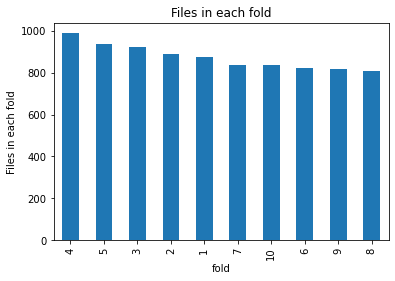

In [4]:
#collapse-show

df.groupby(['fold']).classID.count().sort_values(ascending=False).plot.bar()
plt.ylabel('Files in each fold')
plt.title('Files in each fold')

### Class distribution across the sound types

Text(0.5, 1.0, 'Class distribution in the dataset')

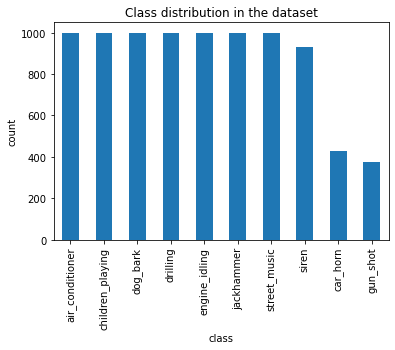

In [5]:
#collapse-show

df.groupby('class').classID.count().sort_values(ascending=False).plot.bar()
plt.ylabel('count')
plt.title('Class distribution in the dataset')

### Model Build

Spider through all the folders for images (transformation of sound to melspectrograms is another notebook). 

In [6]:
# collapse-hide

all_folds = list(np.arange(1,11))
all_folders = [str(i) for i in all_folds]
image_files_loc = 'UrbanSoundTransforms/mel_spectrogram/'
all_files = get_image_files(image_files_loc,recurse=True, folders =all_folders )


### Datablock with an 80-20 Random split on entire dataset

In [7]:
#collapse-hide

dblock = DataBlock(blocks=(ImageBlock,CategoryBlock),
                   get_y     = label_func,
                   splitter  = RandomSplitter(seed=1),
                   
                  )
dl = dblock.dataloaders(all_files)
print ('Train has {0} images and test has {1} images.' .format(len(dl.train_ds),len(dl.valid_ds)))
learn = vision_learner(dl, resnet34, metrics=accuracy)
learn.fine_tune(3)

Train has 6986 images and test has 1746 images.


epoch,train_loss,valid_loss,accuracy,time
0,1.510322,0.698512,0.781787,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.615340,0.356023,0.888889,00:39
1,0.270150,0.213896,0.932990,00:40
2,0.084770,0.181070,0.943299,00:40


### Export the model

In [8]:
#collapse-show

learn.export()